In [2]:
import glob
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
from siuba import group_by, summarize, arrange, filter, mutate, if_else, _
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import torch
from torchvision import transforms
from multimodal.multimodal_lit import MultiModalLitModel
import clip
from sklearn.manifold import TSNE
from PIL import Image

In [7]:
# saycam labeled s results plot
embedding_results = ["../results/saycam/embedding_frozen_pretrained_seed_0_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_frozen_pretrained_seed_1_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_frozen_pretrained_seed_2_image_saycam_test_eval_predictions.json"]
shuffled_results = ["../results/saycam/shuffle_embedding_frozen_pretrained_seed_0_image_saycam_test_eval_predictions.json",
"../results/saycam/shuffle_embedding_frozen_pretrained_seed_1_image_saycam_test_eval_predictions.json",
"../results/saycam/shuffle_embedding_frozen_pretrained_seed_2_image_saycam_test_eval_predictions.json"]
frozen_linear_probe_all_results = ["../results/saycam/embedding_linear_probe_frozen_pretrained_seed_0_image_saycam_eval_predictions.json",
"../results/saycam/embedding_linear_probe_frozen_pretrained_seed_1_image_saycam_eval_predictions.json",
"../results/saycam/embedding_linear_probe_frozen_pretrained_seed_2_image_saycam_eval_predictions.json"]
frozen_linear_probe_1_percent_results = ["../results/saycam/embedding_linear_probe_1_percent_frozen_pretrained_seed_0_image_saycam_eval_predictions.json",
"../results/saycam/embedding_linear_probe_1_percent_frozen_pretrained_seed_1_image_saycam_eval_predictions.json",
"../results/saycam/embedding_linear_probe_1_percent_frozen_pretrained_seed_2_image_saycam_eval_predictions.json"]
frozen_linear_probe_10_percent_results = ["../results/saycam/embedding_linear_probe_10_percent_frozen_pretrained_seed_0_image_saycam_eval_predictions.json",
"../results/saycam/embedding_linear_probe_10_percent_frozen_pretrained_seed_1_image_saycam_eval_predictions.json",
"../results/saycam/embedding_linear_probe_10_percent_frozen_pretrained_seed_2_image_saycam_eval_predictions.json"]
clip_results = ["../results/saycam/clip_image_saycam_test_eval_predictions.json"]

saycam_results = []

for results in embedding_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "contrastive_embedding"
    saycam_results.append(result_df)
    
for results in shuffled_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "contrastive_shuffled"
    saycam_results.append(result_df)
    
for results in frozen_linear_probe_all_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "supervised_linear_probe_all"
    saycam_results.append(result_df)
    
for results in frozen_linear_probe_1_percent_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "supervised_linear_probe_1_percent"
    saycam_results.append(result_df)
    
for results in frozen_linear_probe_10_percent_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "supervised_linear_probe_10_percent"
    saycam_results.append(result_df)
    
for results in clip_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "clip (vit-l/14)"
    result_df["seed"] = 0
    saycam_results.append(result_df)
    
# combine results
saycam_results_df = pd.concat(saycam_results)

# save results
saycam_results_df.to_csv("../results/summary/saycam-bounds-summary.csv")

# summary figure
saycam_summary = (saycam_results_df
>> group_by(_.config, _.seed)
>> summarize(correct = _.correct.mean())
>> arrange(_.correct))

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(8, 8))

(
    so.Plot(saycam_summary, x="correct", y="config", color="config")
    .add(so.Bar(), so.Agg())
    .add(so.Range(), so.Est(errorbar="se"))
    .label(
        x="Text encoder", y="Classification accuracy",
        color=str.capitalize)
    .scale(y=so.Nominal(order=['contrastive_shuffled', 'contrastive_embedding', 'clip (vit-l/14)', 
                               'supervised_linear_probe_1_percent', 'supervised_linear_probe_10_percent', 'supervised_linear_probe_all'][::-1]))
    .label(x="Classification accuracy", y="Model")
    .on(fig)
    .plot()
    #.save('../paper/figures/labeled-s-results.pdf', dpi=300, bbox_inches="tight")
)

ax = plt.gca()
ax.axvline(0.25, linestyle='--', color='grey')

AttributeError: module 'pandas' has no attribute 'to_csv'

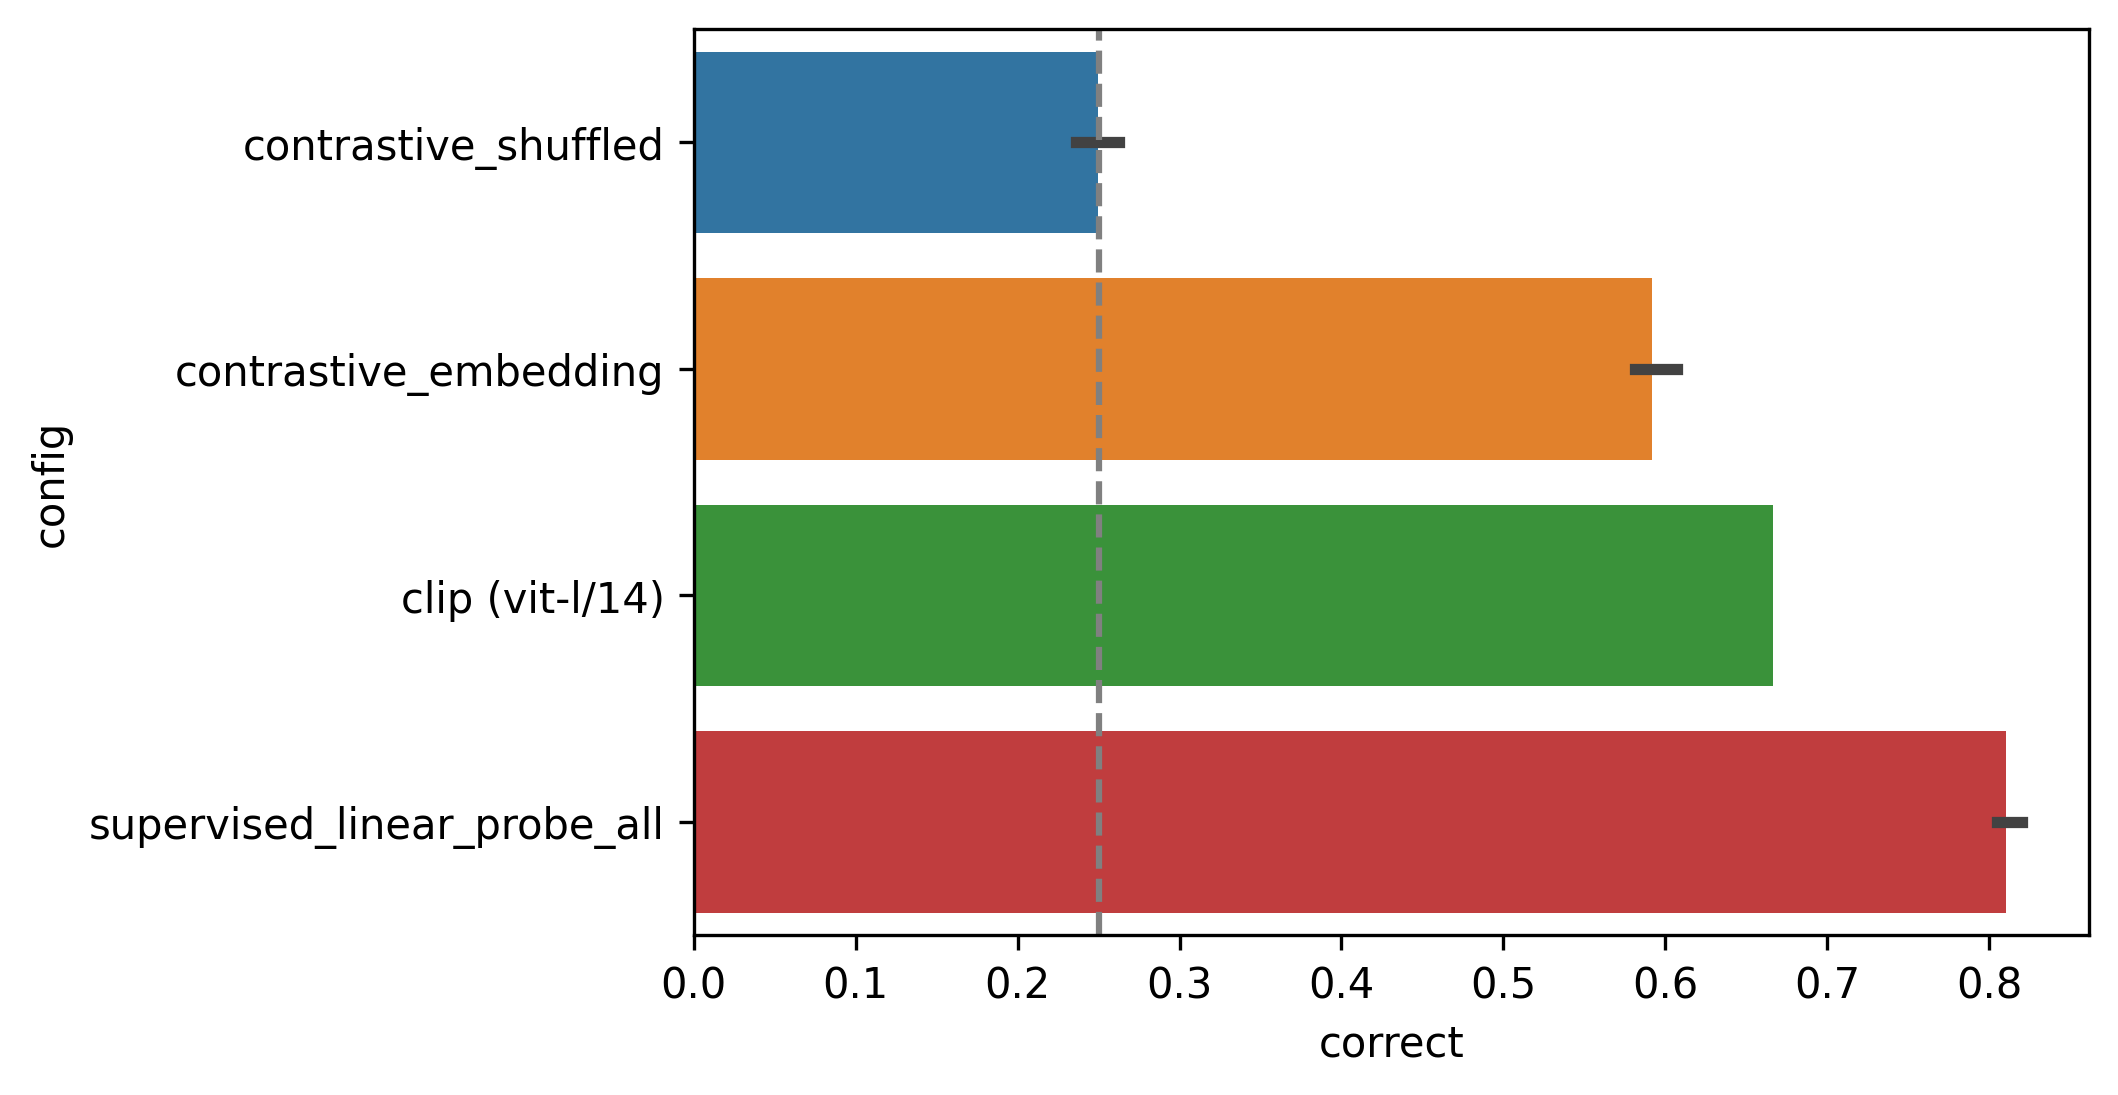

In [3]:
# bar plot of saycam upper and lower bounds
saycam_upper_lower = (saycam_summary 
>> filter(_.config != "supervised_linear_probe_1_percent", _.config != "supervised_linear_probe_10_percent"))

sns.barplot(data=saycam_upper_lower, x="correct", y="config")
ax = plt.gca()
ax.axvline(0.25, linestyle='--', color='grey')

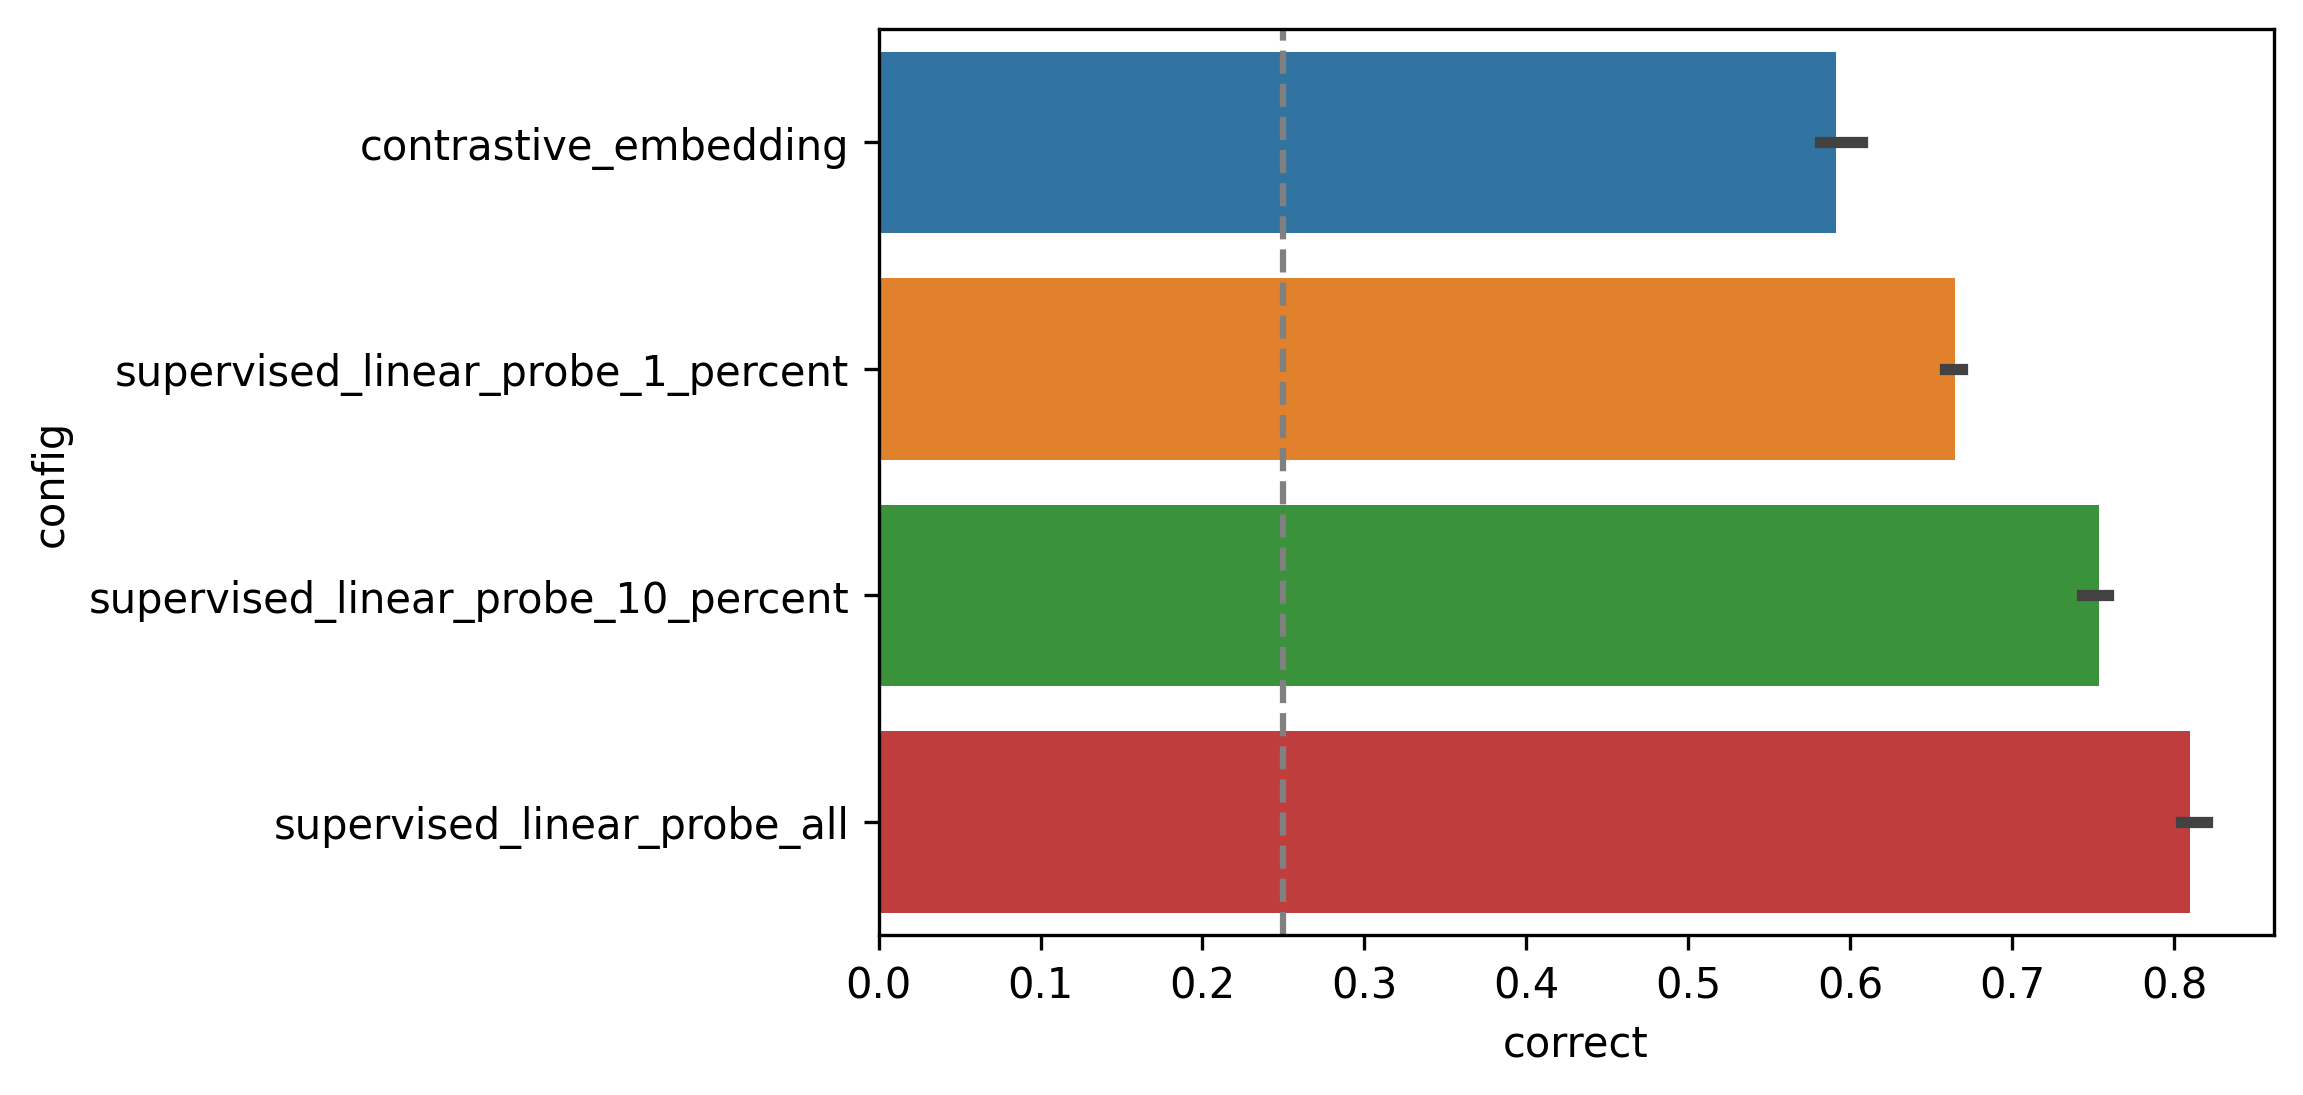

In [4]:
# bar plot of saycam linear probes
saycam_linear_probes = (saycam_summary 
>> filter(_.config != "contrastive_shuffled", _.config != "clip (vit-l/14)"))

sns.barplot(data=saycam_linear_probes, x="correct", y="config")
ax = plt.gca()
ax.axvline(0.25, linestyle='--', color='grey')

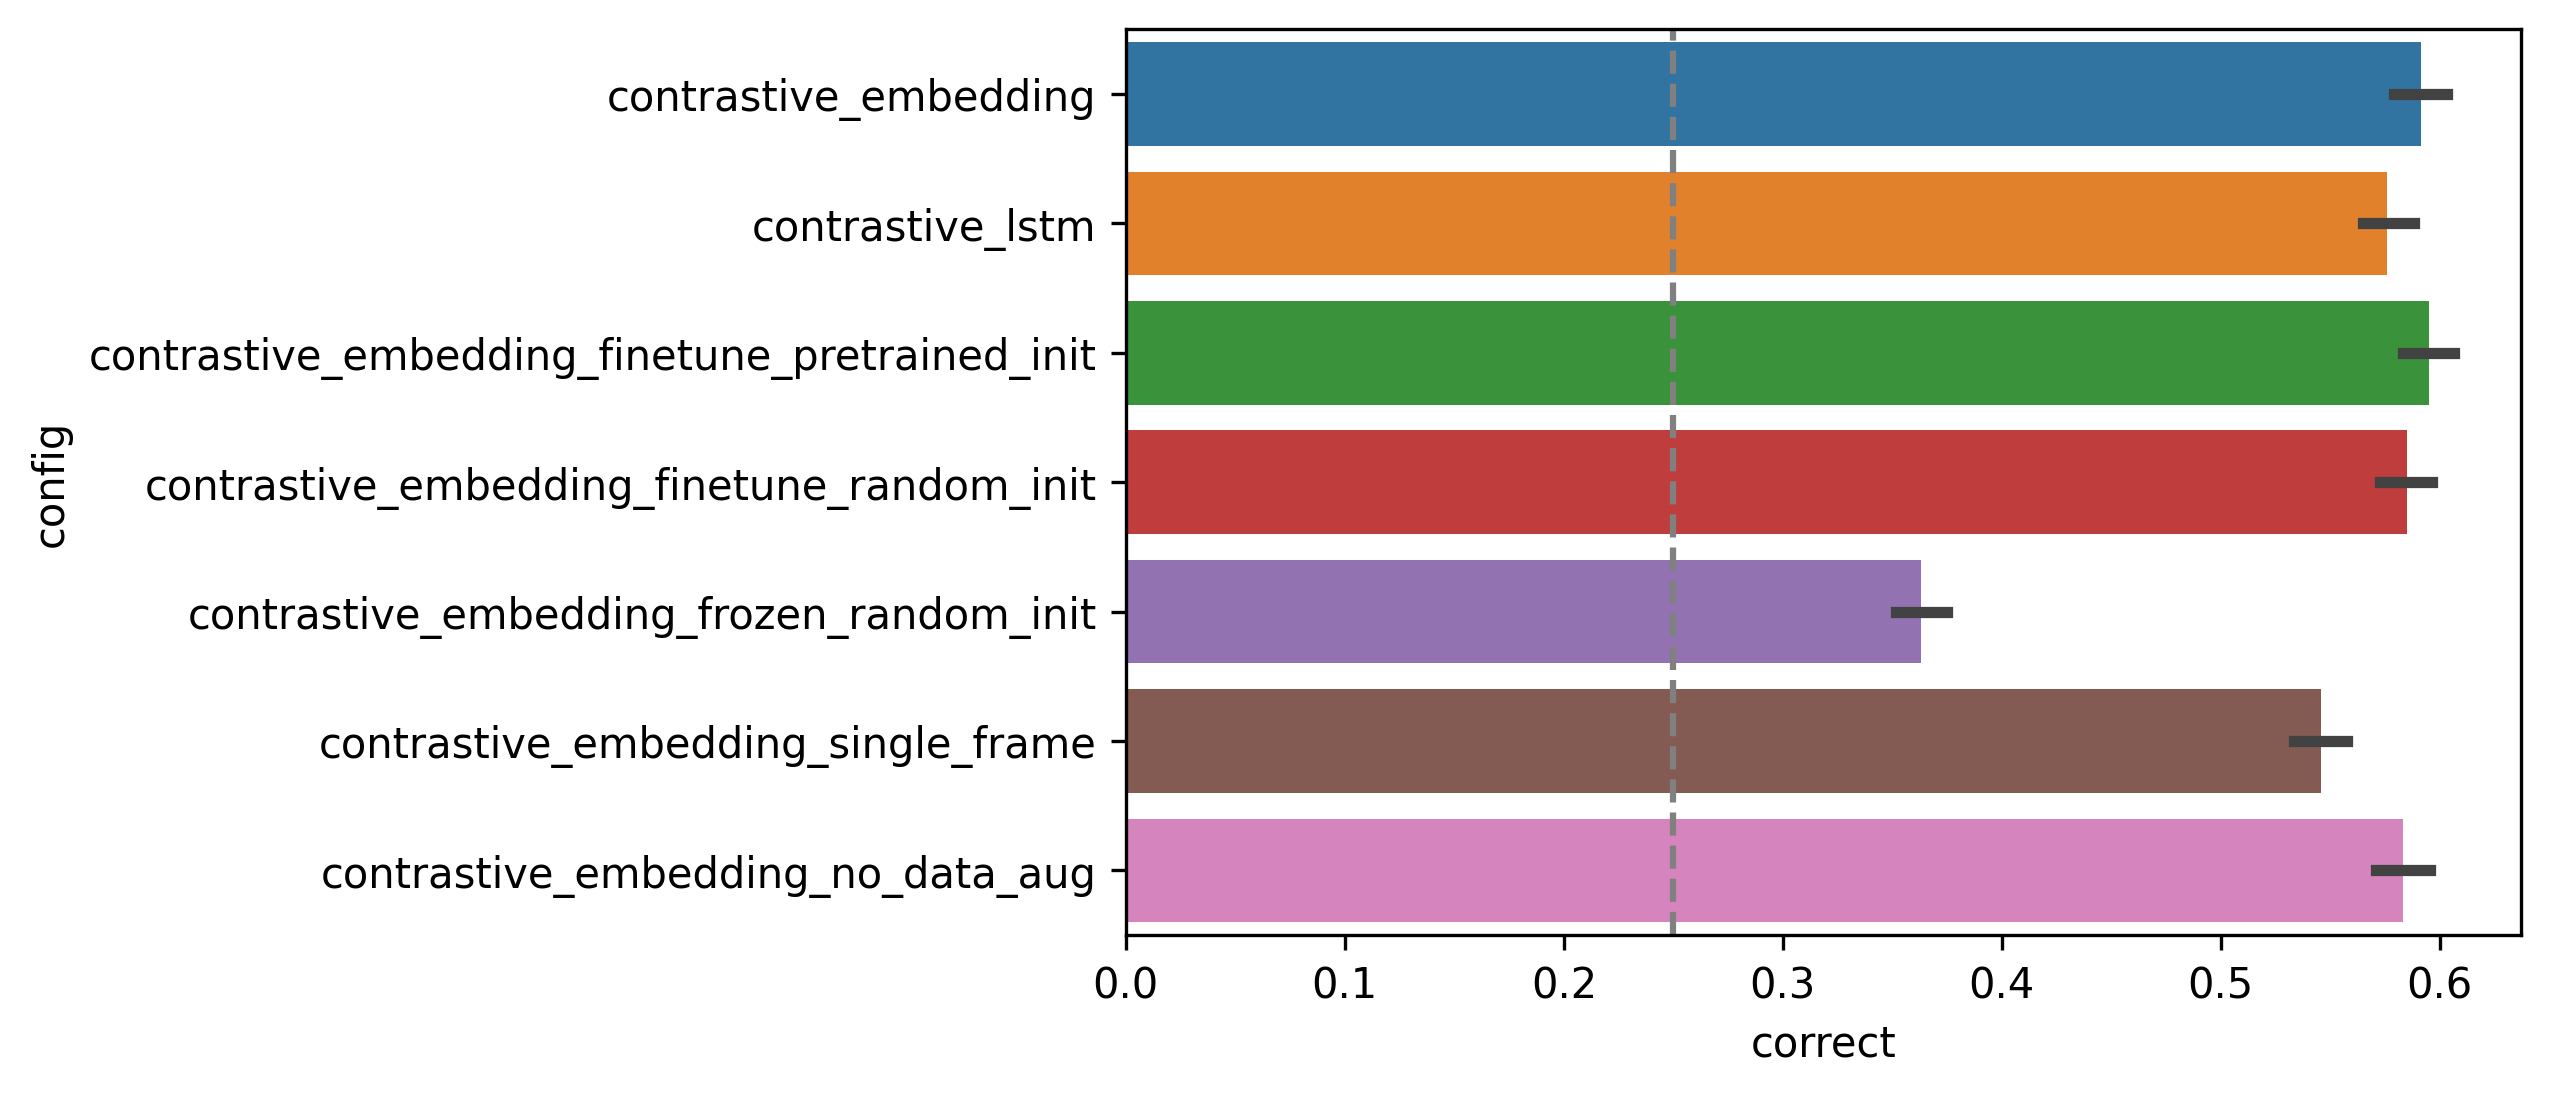

In [10]:
saycam_ablations = []
embedding_results = ["../results/saycam/embedding_frozen_pretrained_seed_0_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_frozen_pretrained_seed_1_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_frozen_pretrained_seed_2_image_saycam_test_eval_predictions.json"]
lstm_results = ["../results/saycam/lstm_frozen_pretrained_seed_0_image_saycam_test_eval_predictions.json",
"../results/saycam/lstm_frozen_pretrained_seed_1_image_saycam_test_eval_predictions.json",
"../results/saycam/lstm_frozen_pretrained_seed_2_image_saycam_test_eval_predictions.json"]
embedding_finetune_pretrained_init_results = ["../results/saycam/embedding_finetune_pretrained_seed_0_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_finetune_pretrained_seed_1_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_finetune_pretrained_seed_2_image_saycam_test_eval_predictions.json"]
embedding_finetune_random_init_results = ["../results/saycam/embedding_finetune_random_init_seed_0_image_saycam_test_eval_predictions.json", 
"../results/saycam/embedding_finetune_random_init_seed_1_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_finetune_random_init_seed_2_image_saycam_test_eval_predictions.json"]
embedding_frozen_random_init_results = ["../results/saycam/embedding_frozen_random_init_seed_0_image_saycam_test_eval_predictions.json", 
"../results/saycam/embedding_frozen_random_init_seed_1_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_frozen_random_init_seed_2_image_saycam_test_eval_predictions.json"]
single_frame_results = ["../results/saycam/embedding_frozen_pretrained_multiple_frames_False_seed_0_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_frozen_pretrained_multiple_frames_False_seed_1_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_frozen_pretrained_multiple_frames_False_seed_2_image_saycam_test_eval_predictions.json"]
no_data_aug_results = ["../results/saycam/embedding_frozen_pretrained_augment_frames_False_seed_0_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_frozen_pretrained_augment_frames_False_seed_1_image_saycam_test_eval_predictions.json",
"../results/saycam/embedding_frozen_pretrained_augment_frames_False_seed_2_image_saycam_test_eval_predictions.json"]

for results in embedding_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "contrastive_embedding"
    saycam_ablations.append(result_df)

for results in lstm_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "contrastive_lstm"
    saycam_ablations.append(result_df)
    
for results in embedding_finetune_pretrained_init_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "contrastive_embedding_finetune_pretrained_init"
    saycam_ablations.append(result_df)
    
for results in embedding_finetune_random_init_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "contrastive_embedding_finetune_random_init"
    saycam_ablations.append(result_df)

for results in embedding_frozen_random_init_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "contrastive_embedding_frozen_random_init"
    saycam_ablations.append(result_df)
    
for results in single_frame_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "contrastive_embedding_single_frame"
    saycam_ablations.append(result_df)
    
for results in no_data_aug_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "contrastive_embedding_no_data_aug"
    saycam_ablations.append(result_df)
    
# import matplotlib as mpl
saycam_ablations = pd.concat(saycam_ablations)

# save results
saycam_ablations.to_csv("../results/summary/saycam-ablations.csv", index=False)

saycam_ablations_summary = (saycam_ablations
>> group_by(_.config, _.seed)
>> summarize(correct = _.correct.mean()))

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
# fig = plt.figure(figsize=(8, 8))

# (
#     so.Plot(saycam_ablations_summary, x="correct", y="config")
#     .add(so.Bar(), so.Agg())
#     .add(so.Range(), so.Est(errorbar="se"))
#     .scale(y=so.Nominal(order=['contrastive_embedding_frozen_random_init', 'contrastive_embedding_single_frame', 'contrastive_embedding_no_data_aug', 'contrastive_embedding_finetune_random_init', 'contrastive_embedding_finetune_pretrained_init', 'contrastive_lstm', 'contrastive_embedding'][::-1]))
#     .on(fig)
#     .plot()
#     # .label(x="Classification accuracy", y="Model")
#     #.save('../paper/figures/labeled-s-results.pdf', dpi=300, bbox_inches="tight")
# )


sns.barplot(data=saycam_ablations, x="correct", y="config")
ax = plt.gca()
ax.axvline(0.25, linestyle='--', color='grey')
# plt.legend([], [], frameon=False)
# ax.get_legend().remove()
# plt.gca().legend([], [], frameon=False).set_visible(False)

In [ ]:
# saycam per object category results
saycam_pretrained_frozen_embedding_results = (saycam_results_df
>> filter(_.config != "contrastive_lstm", _.config != "contrastive_single_frame")                                              
>> group_by(_.config, _.target_category, _.seed)
>> summarize(correct = _.correct.mean()))


(
    so.Plot(saycam_pretrained_frozen_embedding_results, x="correct", y="config", color="config")
    .facet("target_category", wrap=5)
    .add(so.Bar(), so.Agg())
    .add(so.Range(), so.Est(errorbar="se"))
    .scale(y=so.Nominal(order=['contrastive_shuffled', 'contrastive_embedding', 'clip (vit-l/14)', 'supervised_linear_probe'][::-1]))
    .layout(size=(15, 12))
    #.save('../paper/figures/labeled-s-results-by-category.pdf', dpi=300, bbox_inches="tight")
)

In [12]:
object_categories_embedding_results = ["../results/object_categories/embedding_frozen_pretrained_seed_0_image_object_categories_eval_predictions.json",
"../results/object_categories/embedding_frozen_pretrained_seed_1_image_object_categories_eval_predictions.json",
"../results/object_categories/embedding_frozen_pretrained_seed_2_image_object_categories_eval_predictions.json"]

object_categories_results = []

for results in object_categories_embedding_results:
    with open(results) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    result_df["config"] = "Contrastive"
    object_categories_results.append(result_df)
    
# combine results
object_categories_results_df = pd.concat(object_categories_results)

# save as csv
object_categories_results_df.to_csv("../results/summary/object_categories_results.csv")

                                             checkpoint      model  seed  \
0     multimodal_text_encoder_embedding_embedding_di...  embedding     0   
1     multimodal_text_encoder_embedding_embedding_di...  embedding     0   
2     multimodal_text_encoder_embedding_embedding_di...  embedding     0   
3     multimodal_text_encoder_embedding_embedding_di...  embedding     0   
4     multimodal_text_encoder_embedding_embedding_di...  embedding     0   
...                                                 ...        ...   ...   
4760  multimodal_text_encoder_embedding_embedding_di...  embedding     2   
4761  multimodal_text_encoder_embedding_embedding_di...  embedding     2   
4762  multimodal_text_encoder_embedding_embedding_di...  embedding     2   
4763  multimodal_text_encoder_embedding_embedding_di...  embedding     2   
4764  multimodal_text_encoder_embedding_embedding_di...  embedding     2   

      shuffle_utterances                cnn eval_type       eval_dataset  \
0          

In [ ]:
# brady object categories results
brady_results_filenames = glob.glob("../results/saycam/*object_categories*.json")
print(len(brady_results_filenames))

brady_results = []
for filename in brady_results_filenames:
    with open(filename) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    # print(result_df.columns)
    result_df["target_category"] = result_df["categories"].str[0]
    brady_results.append(result_df)

# combine results
brady_results_df = pd.concat(brady_results)

# calculate summary
brady_summary_diff_init = (brady_results_df
>> filter(_.shuffle_utterances == False, _.eval_type == "image", _.cnn == "frozen_pretrained")
>> group_by(_.cnn, _.model, _.seed)
>> summarize(correct = _.correct.mean()))

In [ ]:
# brady per object category results
from itertools import chain
brady_pretrained_frozen_embedding_results = (brady_results_df
>> filter(_.shuffle_utterances == False, _.cnn == "frozen_pretrained", _.model == "embedding", _.eval_type =="image")
>> group_by(_.target_category, _.seed)
>> summarize(correct = _.correct.mean())
>> arrange(_.correct)
>> mutate(row=list(chain(*[[i]*96 for i in range(2)]))))


(
    so.Plot((brady_pretrained_frozen_embedding_results), x="correct", y="target_category")
    # .facet(col="target_category", wrap=8)
    .add(so.Dot(), so.Agg())
    .add(so.Range(), so.Est(errorbar="se"))
    .layout(size=(6, 14))
)

In [ ]:
# try plotting as a line graph instead



In [3]:
# visualize embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normalizer = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

preprocess = transforms.Compose([
            transforms.Resize((224, 224),
                              interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            normalizer,
        ])

# load embedding checkpoint
checkpoint_name = f"multimodal_text_encoder_embedding_embedding_dim_512_batch_size_8_dropout_i_0.5_lr_0.0001_lr_scheduler_True_weight_decay_0.1_max_epochs_400_seed_0"
checkpoint = glob.glob(f"/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/{checkpoint_name}/epoch*.ckpt")[0]
model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
model.eval()
print("")

In [4]:
# get image embeddings
DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
# EVALUATION_FRAMES_DIR = DATA_DIR / "eval_filtered" / "test"
EVALUATION_FRAMES_DIR = DATA_DIR / "eval" / "test"
eval_categories = sorted(os.listdir(EVALUATION_FRAMES_DIR))

all_image_features = []
all_eval_categories = []
all_image_filenames = []

for eval_category in eval_categories:
    frames = sorted(glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg")))
    print(eval_category, len(frames))
    frames = np.random.choice(frames, size=min(len(frames), 200))
    
    for frame in frames:
        I = preprocess(Image.open(frame).convert('RGB')).unsqueeze(0).to(device)
        image_features, _ = model.model.encode_image(I)
        all_image_features.append(image_features.squeeze().detach().cpu().numpy())
        all_eval_categories.append(eval_category)
        all_image_filenames.append(frame)

ball 2107


/home/wv9/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


basket 74
car 646
cat 752
chair 535
computer 841
crib 460
door 1268
floor 2718
foot 408
ground 1091
hand 1547
kitchen 1080
paper 716
puzzle 1529
road 1741
room 1979
sand 318
stairs 477
table 1324
toy 4307
window 1189


In [5]:
VOCAB_FILENAME = DATA_DIR / "vocab.json"
with open(VOCAB_FILENAME) as f:
    vocab = json.load(f)
    
all_text_features = []
eval_categories[3] = "kitty"  # match eval set-up

for eval_category in eval_categories:
    text = torch.tensor([vocab[eval_category]]).unsqueeze(0).to(device)
    text_len = torch.tensor([len(text)], dtype=torch.long).to(device)
    text_features, _ = model.model.encode_text(text, text_len)
    all_text_features.append(text_features.squeeze().detach().cpu().numpy())

In [6]:
# get mean image embeddings
all_image_features = np.array(all_image_features)
mean_image_features = []
eval_categories[3] = "cat"  # hack to fix indexing below

for i in range(len(eval_categories)):
    idxs = [j for j in range(len(all_eval_categories)) if all_eval_categories[j] == eval_categories[i]]
    curr_image_features = all_image_features[idxs]
    curr_mean_image_features = np.mean(curr_image_features, axis=0)
    mean_image_features.append(curr_mean_image_features)

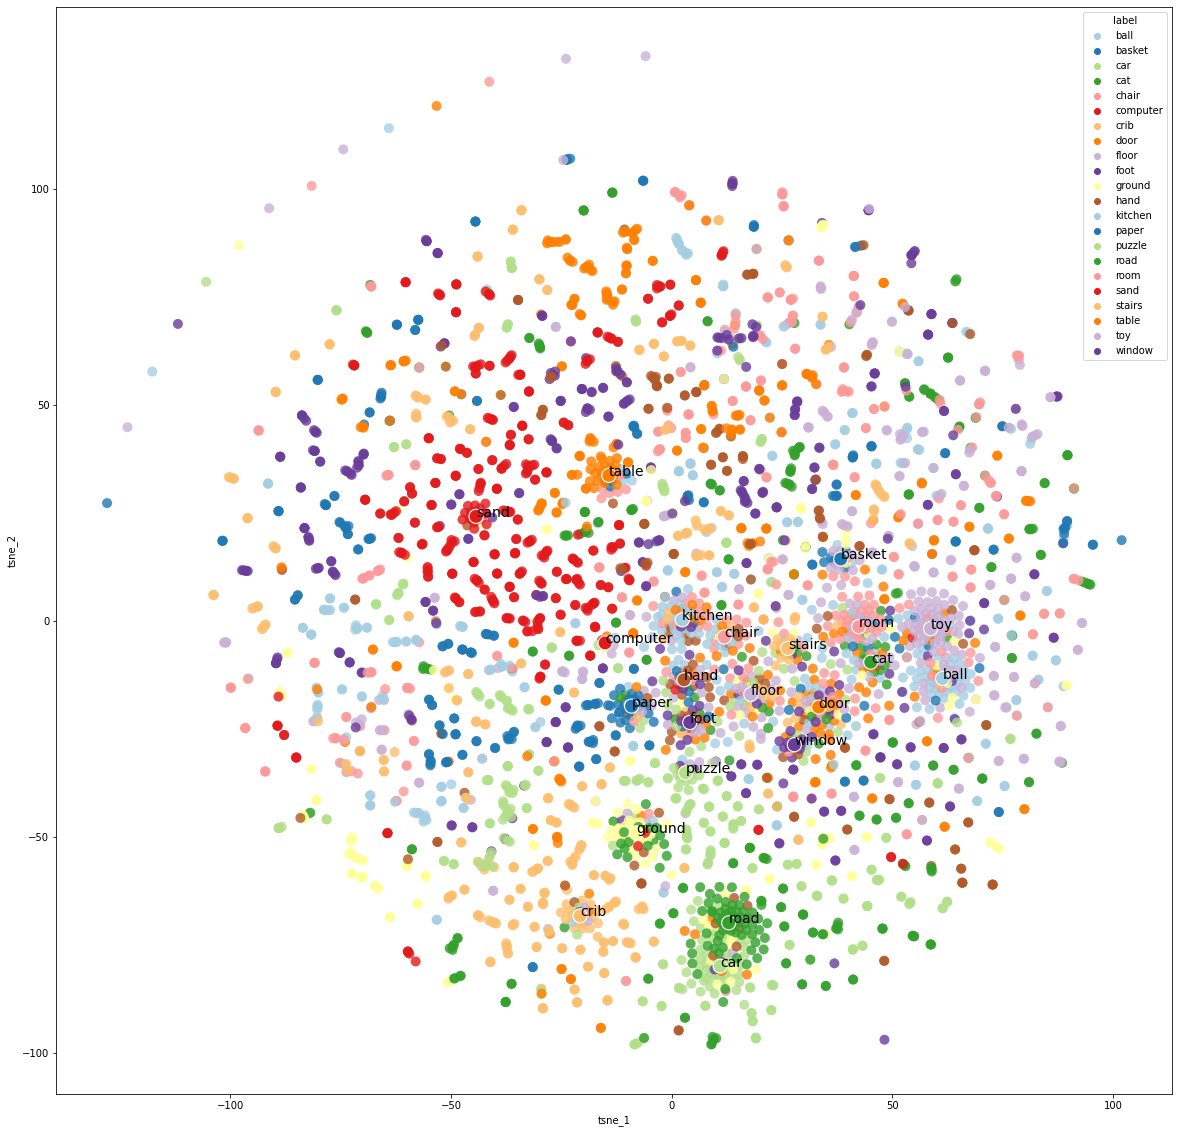

In [8]:
# plot image embeddings
n_components = 2
tsne = TSNE(n_components, perplexity=2)
all_mean_image_features = np.concatenate([all_image_features, mean_image_features])
tsne_result = tsne.fit_transform(all_mean_image_features)
all_tsne_result = tsne_result[:-22]
mean_tsne_result = tsne_result[-22:]
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': all_tsne_result[:,0], 'tsne_2': all_tsne_result[:,1], 'label': all_eval_categories})
mean_tsne_result_df = pd.DataFrame({'tsne_1': mean_tsne_result[:,0], 'tsne_2': mean_tsne_result[:,1], 'label': eval_categories})
fig = plt.figure(figsize=(20, 20))

ax = plt.gca()
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=100, legend="auto", palette="Paired", linewidth=0, alpha=0.8)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=mean_tsne_result_df, s=200, legend=False, palette="Paired")
lim = (tsne_result.min()-5, tsne_result.max()+5)
for i, eval_category in enumerate(eval_categories):
    ax.text(mean_tsne_result[i, 0], mean_tsne_result[i, 1], eval_category, size=14)

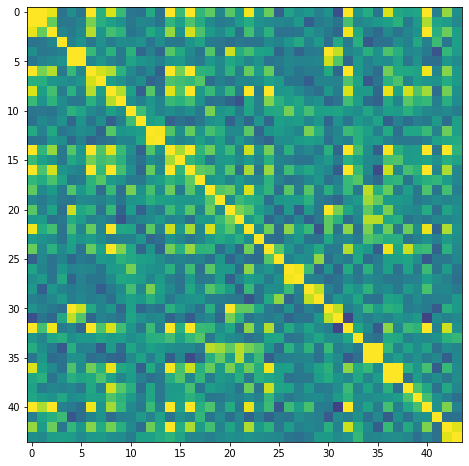

In [72]:
import torch.nn.functional as F

# combined_features = np.concatenate([mean_image_features, all_text_features])
# print(combined_features.shape)
combined_features = []
for i in range(22):
    combined_features.append(mean_image_features[i])
    combined_features.append(all_text_features[i])
combined_features = np.array(combined_features)
        
combined_sims = np.zeros((len(combined_features), len(combined_features)))
for i in range(len(combined_features)):
    for j in range(len(combined_features)):
        x1 = F.normalize(torch.Tensor(combined_features[i]), p=2, dim=0)
        x2 = F.normalize(torch.Tensor(combined_features[j]), p=2, dim=0)
        combined_sims[i, j] = torch.nn.functional.cosine_similarity(x1, x2, dim=0)  

plt.figure(figsize=(8, 8))
plt.imshow(combined_sims, vmin=-0.5, vmax=0.5) 


/home/wv9/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


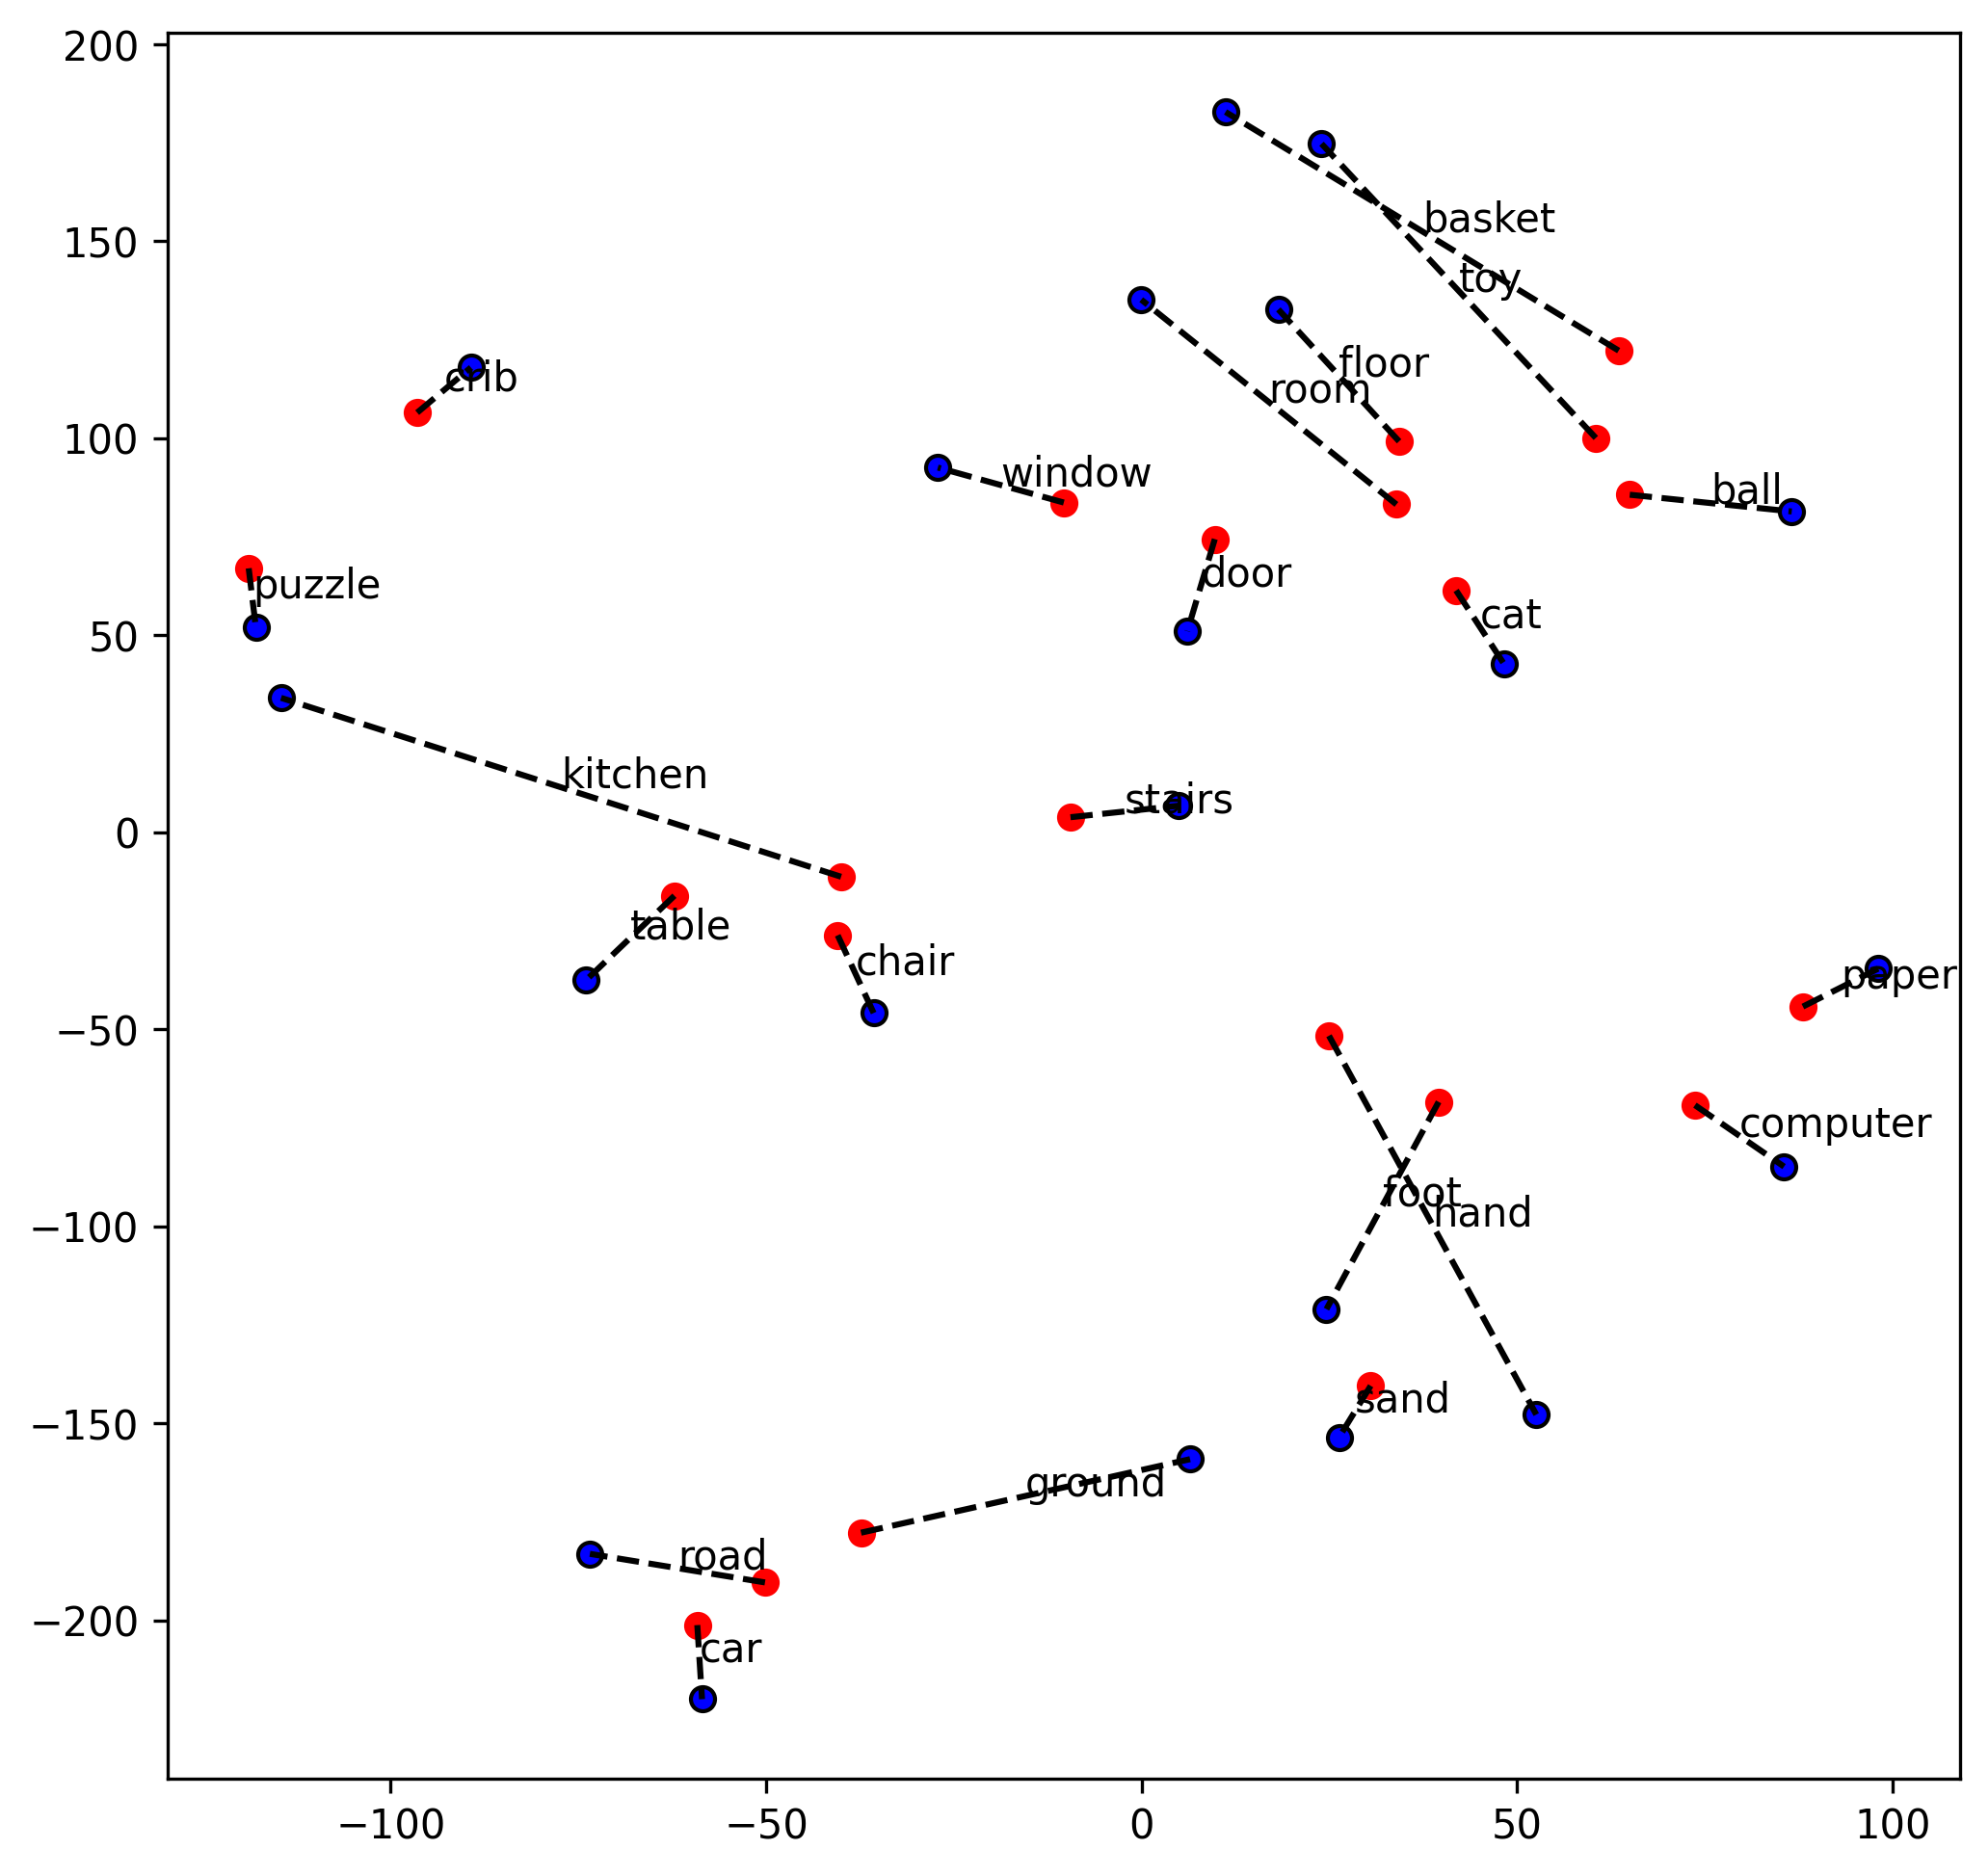

In [73]:
from sklearn import manifold

# set-up t-sne model
tsne_model = manifold.TSNE(random_state=1, metric="precomputed", perplexity=5)

# normalize similarity scores to be between 0 and 1
normalized_sims = (combined_sims-np.min(combined_sims))/(np.max(combined_sims)-np.min(combined_sims))

# invert similarity scores since t-sne takes in a distance matrix
Y = tsne_model.fit_transform(1 - normalized_sims)

plt.figure(figsize=(8, 8), dpi=300)
for i in range(0, len(Y), 2):
    plt.plot(Y[i:i+2, 0], Y[i:i+2, 1], '--', color="black")

for i in range(0, len(Y)):
    if i % 2 == 0:
        plt.scatter(Y[i, 0], Y[i, 1], color="red")
    else:
        plt.scatter(Y[i, 0], Y[i, 1], color="blue", edgecolors= "black")

for i, eval_category in enumerate(eval_categories):
    plt.annotate(eval_category, ((Y[2*i, 0]+Y[(2*i)+1, 0])/2, (Y[2*i, 1]+Y[(2*i)+1, 1])/2))    

([], [])

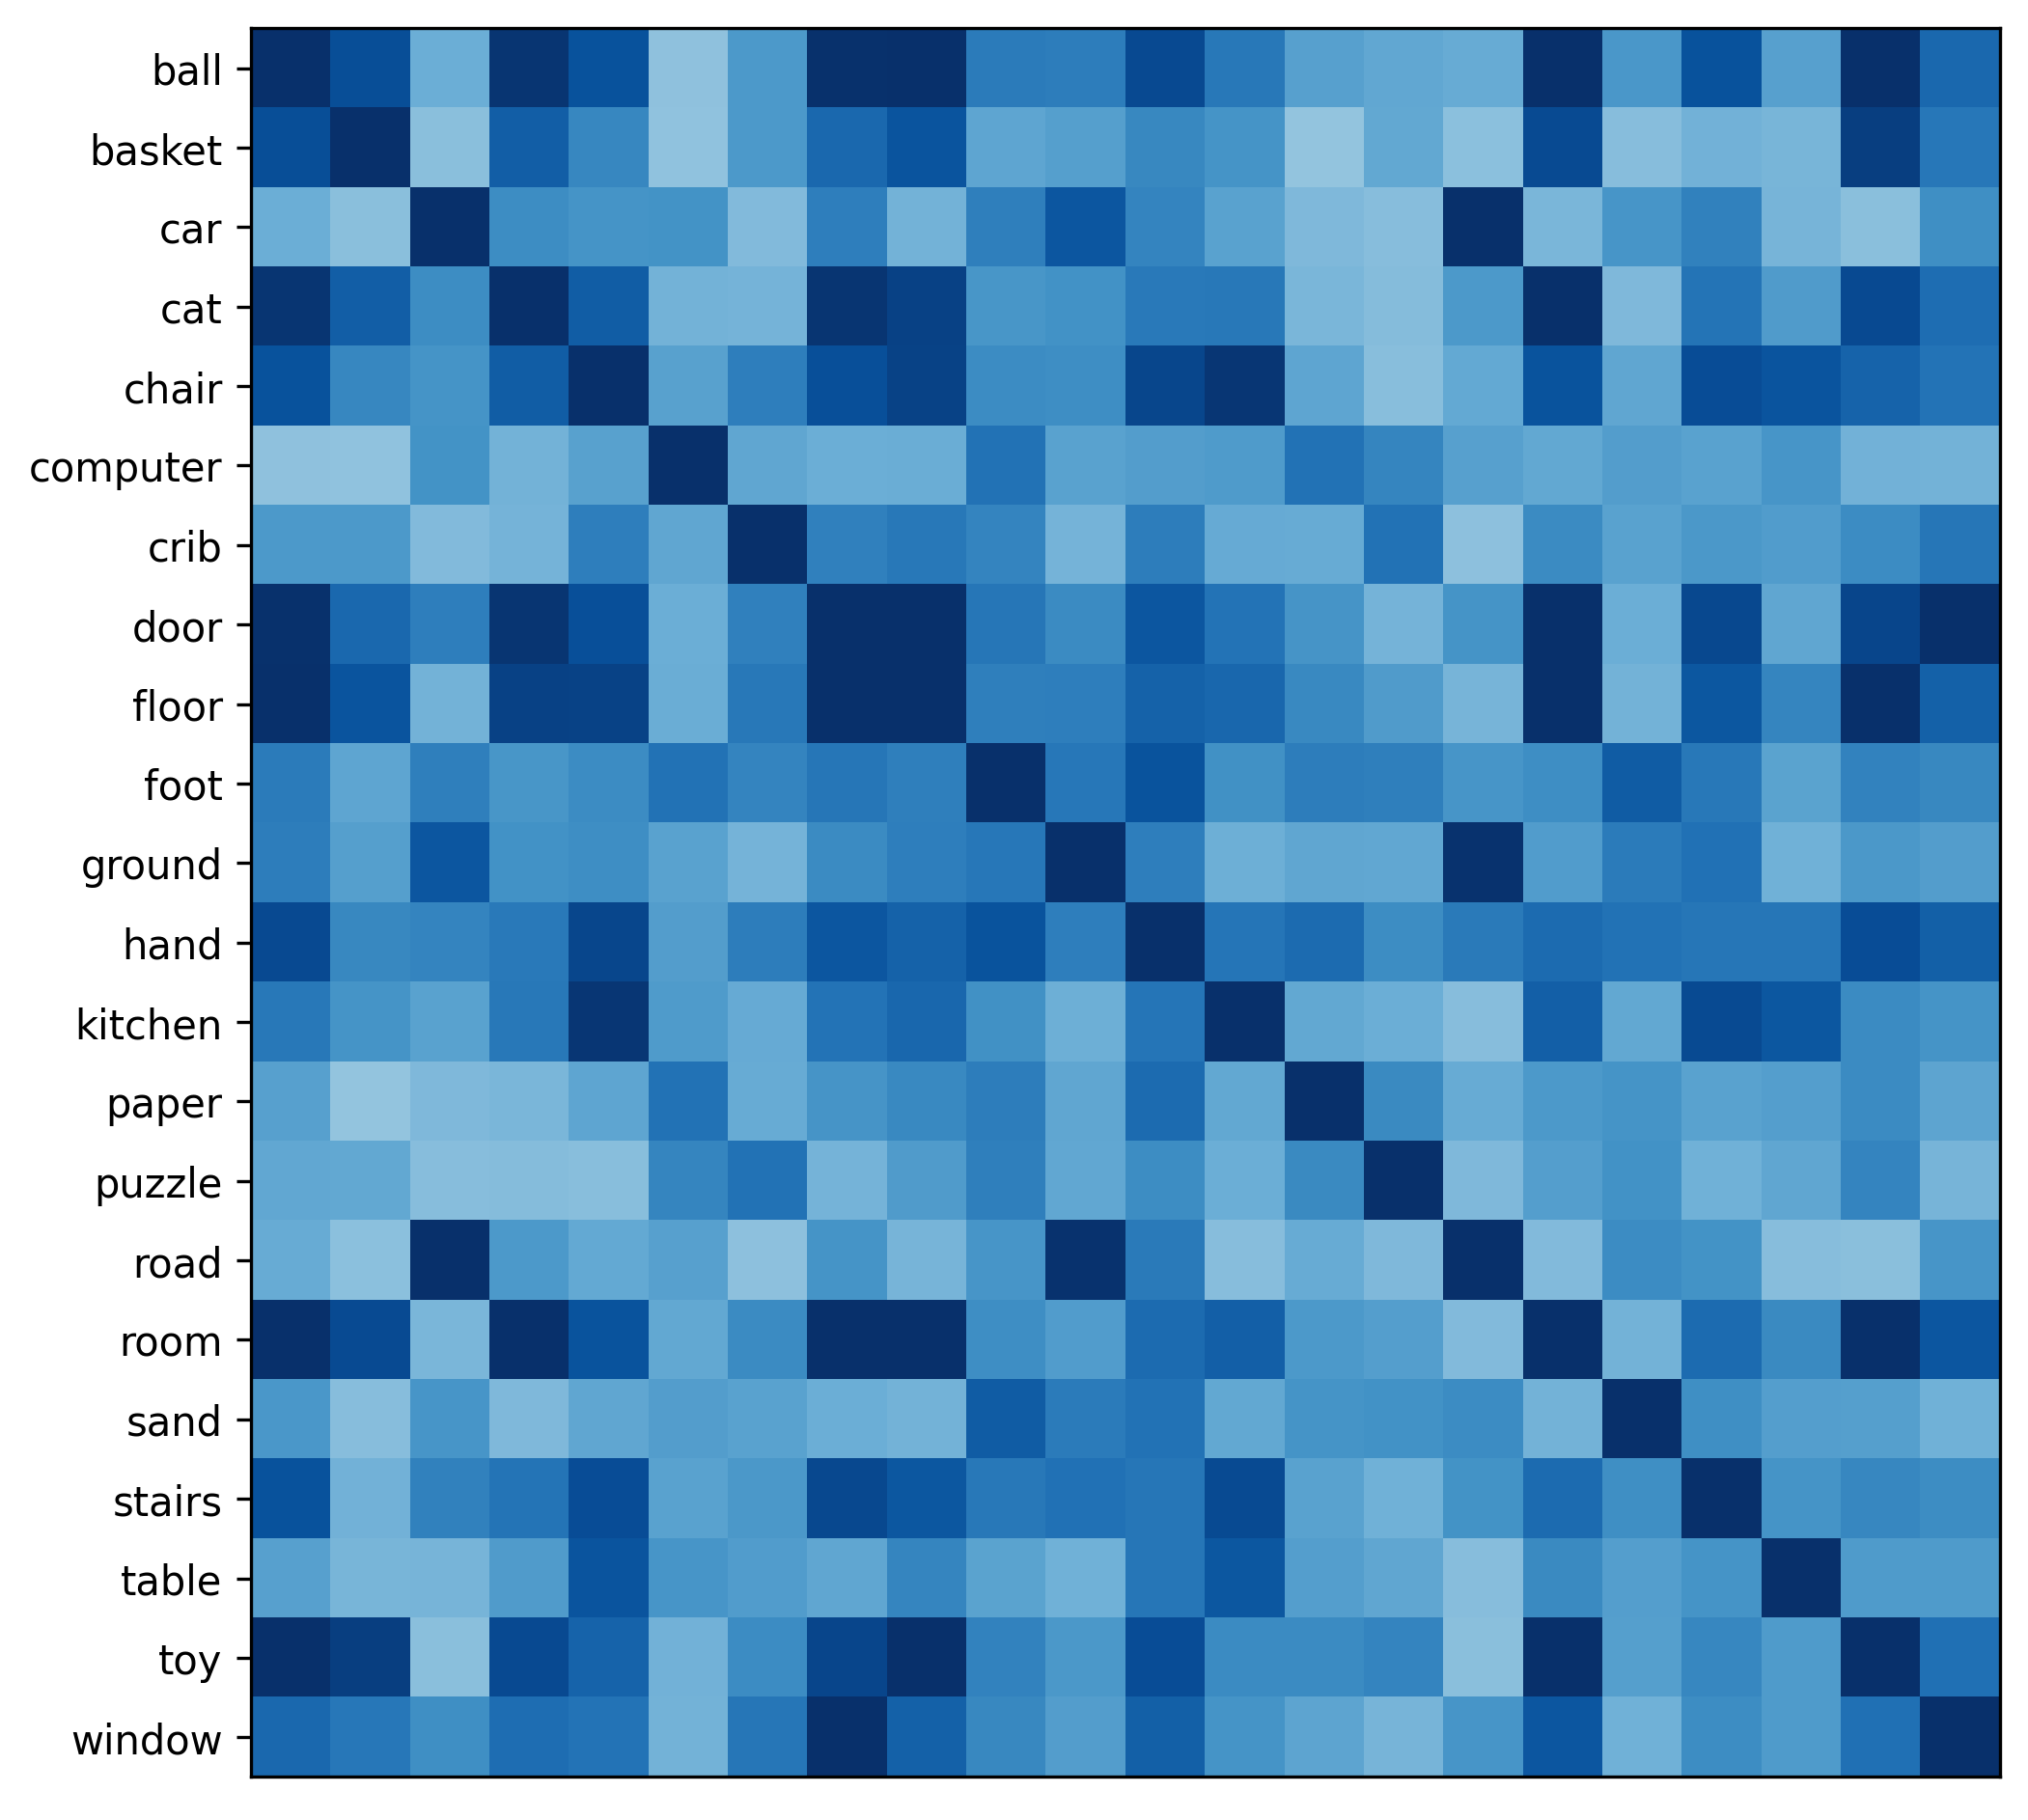

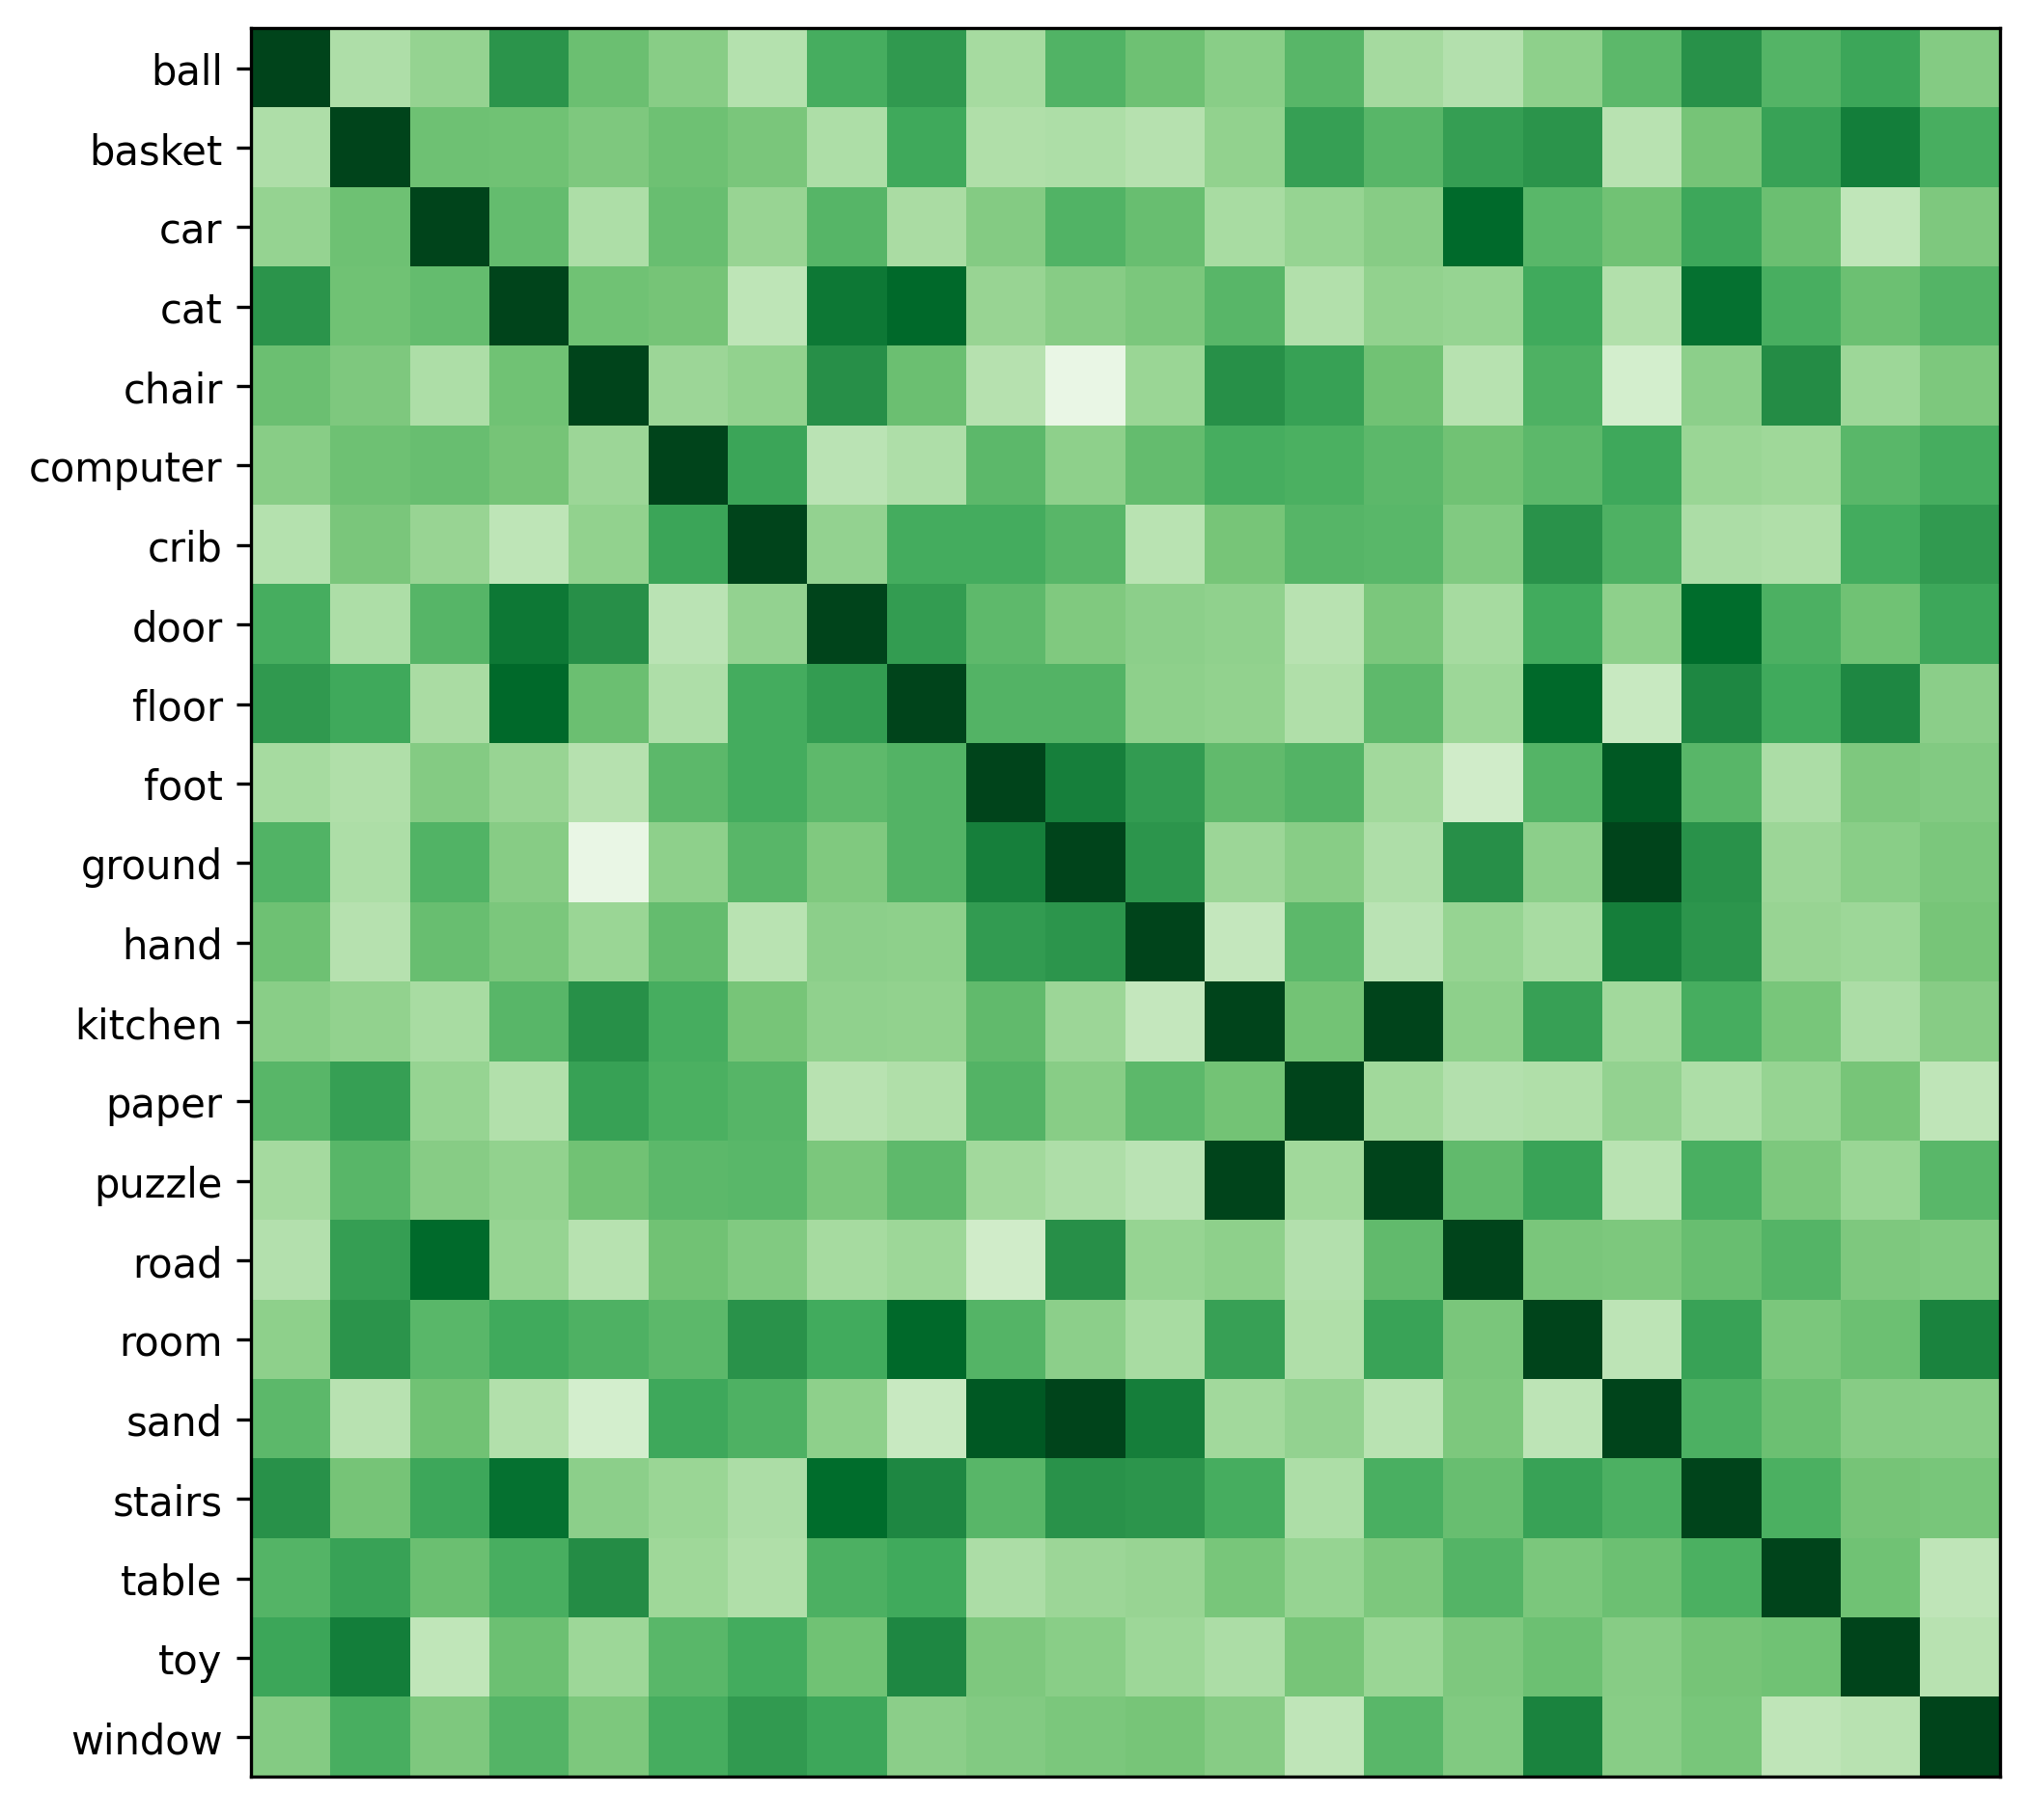

In [74]:
# calculate pearson similarity
# get image and text sims separately
image_sims = np.zeros((len(mean_image_features), len(mean_image_features)))
text_sims = np.zeros((len(all_text_features), len(all_text_features)))

for i in range(len(mean_image_features)):
    for j in range(len(mean_image_features)):
        x1 = F.normalize(torch.Tensor(mean_image_features[i]), p=2, dim=0)
        x2 = F.normalize(torch.Tensor(mean_image_features[j]), p=2, dim=0)
        image_sims[i, j] = torch.nn.functional.cosine_similarity(x1, x2, dim=0) 
        
for i in range(len(all_text_features)):
    for j in range(len(all_text_features)):
        x1 = F.normalize(torch.Tensor(all_text_features[i]), p=2, dim=0)
        x2 = F.normalize(torch.Tensor(all_text_features[j]), p=2, dim=0)
        text_sims[i, j] = torch.nn.functional.cosine_similarity(x1, x2, dim=0)          
        
plt.figure(figsize=(8, 8), dpi=300)
ax = plt.gca()
plt.imshow(image_sims, vmin=-0.6, vmax=0.6, cmap="Blues") 
ax.set_yticks(range(22))
ax.set_yticklabels(eval_categories)
plt.xticks([])

plt.figure(figsize=(8, 8), dpi=300)
ax = plt.gca()
plt.imshow(text_sims, vmin=-0.3, vmax=0.3, cmap="Greens")
ax.set_yticks(range(22))
ax.set_yticklabels(eval_categories)
plt.xticks([])

In [75]:
import scipy

# calculate pearson correlation
image_sims_upper = image_sims[np.triu_indices_from(image_sims, k=1)]
text_sims_upper = text_sims[np.triu_indices_from(text_sims, k=1)]

print(scipy.stats.pearsonr(image_sims_upper, text_sims_upper))

(0.42063991922086497, 2.5487145776140626e-11)


In [ ]:
# plot text embeddings
# n_components = 2
# tsne = TSNE(n_components, perplexity=5)
# tsne_result = tsne.fit_transform(all_text_features)
 
# # Plot the result of our TSNE with the label color coded
# # A lot of the stuff here is about making the plot look pretty and not TSNE
# tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': eval_categories})
# fig = plt.figure(figsize=(20, 20))

# ax = plt.gca()
# sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=200, legend=False, palette="Paired")
# lim = (tsne_result.min()-5, tsne_result.max()+5)
# for i, eval_category in enumerate(eval_categories):
#     ax.text(tsne_result[i, 0], tsne_result[i, 1], eval_category, size=32)

In [ ]:
# recompute all image features
all_image_features = []
all_eval_categories = []

for eval_category in eval_categories:
    frames = sorted(glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg")))
    
    for frame in frames:
        I = preprocess(Image.open(frame).convert('RGB')).unsqueeze(0).to(device)
        image_features, _ = model.model.encode_image(I)
        all_image_features.append(image_features.squeeze().detach().cpu().numpy())
        all_eval_categories.append(eval_category)

In [ ]:
n_components = 2
tsne = TSNE(n_components, perplexity=1.5)
all_mean_image_features = np.concatenate([all_image_features, mean_image_features])
tsne_result = tsne.fit_transform(all_mean_image_features)
all_tsne_result = tsne_result[:-22]
mean_tsne_result = tsne_result[-22:]

In [ ]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
curr_category = "foot"
category_idx = eval_categories.index(curr_category)
sims = []
for image_feature in all_image_features:
    sim = np.power(np.dot(image_feature, all_text_features[category_idx]) / (np.linalg.norm(image_feature)*np.linalg.norm(all_text_features[category_idx])), 2)
    sims.append(sim)

sims = np.array(sims)
sims = (sims - np.min(sims))/np.ptp(sims)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
mean_tsne_result_df = pd.DataFrame({'tsne_1': mean_tsne_result[:,0], 'tsne_2': mean_tsne_result[:,1], 'label': eval_categories})

ax.set_title(curr_category)
# ax = plt.gca()
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, s=50, color='blue', legend='full', alpha=sims, linewidth=0)
lim = (tsne_result.min()-5, tsne_result.max()+5)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=mean_tsne_result_df, s=200, legend=False, palette="Paired", linewidth=0)
for i, eval_category in enumerate(eval_categories):
    ax.text(mean_tsne_result[i, 0], mean_tsne_result[i, 1], eval_category, size=14)

In [ ]:
fig = plt.figure(figsize=(50, 40))
for i, curr_category in enumerate(eval_categories):
    category_idx = eval_categories.index(curr_category)
    sims = []
    for image_feature in all_image_features:
        sim = np.power(np.dot(image_feature, all_text_features[category_idx]) / (np.linalg.norm(image_feature)*np.linalg.norm(all_text_features[category_idx])), 2)
        sims.append(sim)

    sims = np.array(sims)
    sims = (sims - np.min(sims))/np.ptp(sims)

    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
    mean_tsne_result_df = pd.DataFrame({'tsne_1': mean_tsne_result[:,0], 'tsne_2': mean_tsne_result[:,1], 'label': eval_categories})

    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title(curr_category)
    # ax = plt.gca()
    sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, s=25, color='blue', legend='full', alpha=sims)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=mean_tsne_result_df, s=50, legend=False, palette="Paired")
    for j, eval_category in enumerate(eval_categories):
        ax.text(mean_tsne_result[j, 0], mean_tsne_result[j, 1], eval_category, size=12)

In [ ]:
# extract image embeddings prior to linear projection layer
import torch.nn as nn
self_sup_model = torch.nn.Sequential(*(list(model.vision_encoder.model.children())[:-1]))
x = torch.randn(1, 3, 224, 224).to(device)
y = self_sup_model(x)

# # get image embeddings
DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
EVALUATION_FRAMES_DIR = DATA_DIR / "eval_filtered" / "test"
eval_categories = sorted(os.listdir(EVALUATION_FRAMES_DIR))

all_image_features = []
all_eval_categories = []
all_image_filenames = []

for eval_category in eval_categories:
    frames = sorted(glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg")))
    print(eval_category, len(frames))
    # frames = np.random.choice(frames, size=min(len(frames), 200))
    
    for frame in frames:
        I = preprocess(Image.open(frame).convert('RGB')).unsqueeze(0).to(device)
        image_features = self_sup_model(I).squeeze()
        all_image_features.append(image_features.squeeze().detach().cpu().numpy())
        all_eval_categories.append(eval_category)
        all_image_filenames.append(frame)

In [ ]:
# get mean image embeddings
all_image_features = np.array(all_image_features)
mean_image_features = []
for i in range(len(eval_categories)):
    idxs = [j for j in range(len(all_eval_categories)) if all_eval_categories[j] == eval_categories[i]]
    curr_image_features = all_image_features[idxs]
    curr_mean_image_features = np.mean(curr_image_features, axis=0)
    mean_image_features.append(curr_mean_image_features)
    
mean_image_features = np.array(mean_image_features)

n_components = 2
tsne = TSNE(n_components, perplexity=2)
all_mean_image_features = np.concatenate([all_image_features, mean_image_features])
tsne_result = tsne.fit_transform(all_mean_image_features)
all_tsne_result = tsne_result[:-22]
mean_tsne_result = tsne_result[-22:]
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': all_tsne_result[:,0], 'tsne_2': all_tsne_result[:,1], 'label': all_eval_categories})
mean_tsne_result_df = pd.DataFrame({'tsne_1': mean_tsne_result[:,0], 'tsne_2': mean_tsne_result[:,1], 'label': eval_categories})
fig = plt.figure(figsize=(20, 20))

ax = plt.gca()
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=100, legend="auto", palette="Paired", linewidth=0, alpha=0.8)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=mean_tsne_result_df, s=200, legend=False, palette="Paired")
lim = (tsne_result.min()-5, tsne_result.max()+5)
for i, eval_category in enumerate(eval_categories):
    ax.text(mean_tsne_result[i, 0], mean_tsne_result[i, 1], eval_category, size=14)